<a href="https://colab.research.google.com/github/Ignaciojeda/ProyectoCSSCrisDm/blob/main/Regresion_Logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar librerias

In [ ]:
# Librerías generales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler




#Importar DataSet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

url = '/content/drive/MyDrive/TG_Machine_Learning/datos_datacss.csv'
# Cargar los datos
try:
    data = pd.read_csv(url, sep=",", encoding='latin-1', low_memory=False)
    print("Datos cargados exitosamente!")
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Mounted at /content/drive
Datos cargados exitosamente!


#Separar Variables

In [ ]:
# Codificar variable MatchResult (Ganados = 1)
le = LabelEncoder()
data['MatchResult'] = le.fit_transform(data['MatchResult'])
if le.classes_[0] == 'Ganados':  # Asegura que 'Ganados' sea 1
    data['MatchResult'] = 1 - data['MatchResult']


In [ ]:
features = [
    'RLethalGrenadesThrown',
    'RoundKills',
    'RoundAssists',
    'RoundHeadshots',
    'RoundFlankKills',
    'Survived',
    'RoundStartingEquipmentValue',
    'TeamStartingEquipmentValue',
    'MatchKills',
    'MatchFlankKills',
    'MatchAssists',
    'MatchHeadshots',
    'outlier'
]

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])


In [ ]:
df_agg = data.groupby(['MatchId', 'InternalTeamId', 'MatchResult']).agg(
    Avg_RLethalGrenadesThrown=('RLethalGrenadesThrown', 'mean'),
    Sum_RoundKills=('RoundKills', 'sum'),
    Sum_RoundAssists=('RoundAssists', 'sum'),
    Avg_RoundHeadshots=('RoundHeadshots', 'mean'),
    Avg_RoundFlankKills=('RoundFlankKills', 'mean'),
    Avg_Survived=('Survived', 'mean'),
    Avg_RoundStartingEquipmentValue=('RoundStartingEquipmentValue', 'mean'),
    Avg_TeamStartingEquipmentValue=('TeamStartingEquipmentValue', 'mean'),
    Sum_MatchKills=('MatchKills', 'first'),
    Sum_MatchFlankKills=('MatchFlankKills', 'first'),
    Sum_MatchAssists=('MatchAssists', 'first'),
    Sum_MatchHeadshots=('MatchHeadshots', 'first'),
    Avg_outlier=('outlier', 'mean')
).reset_index()

X = df_agg.drop(columns=['MatchId', 'InternalTeamId', 'MatchResult'])
y = df_agg['MatchResult']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


#Entrenamiento del modelo

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

#Predicciones

In [ ]:
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.935

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       105
           1       0.90      0.97      0.93        95

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200


Matriz de confusión:
[[95 10]
 [ 3 92]]


#Prediccion de supervivencia

In [ ]:
# Probabilidad de sobrevivir (clase 1)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Mostrar primeras 10
print(y_proba[:10])


[0.00526289 0.98133685 0.00702452 0.00727248 0.91972754 0.14636417
 0.13527958 0.77213039 0.1218834  0.3038395 ]


#Cuanto influye

In [ ]:
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': logreg.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

print(coef_df)


                           Variable  Coeficiente
12                      Avg_outlier     0.611351
4               Avg_RoundFlankKills     0.008300
2                  Sum_RoundAssists    -0.000671
10                 Sum_MatchAssists    -0.031948
1                    Sum_RoundKills    -0.193722
3                Avg_RoundHeadshots    -0.245418
6   Avg_RoundStartingEquipmentValue    -0.301522
7    Avg_TeamStartingEquipmentValue    -0.326087
9               Sum_MatchFlankKills    -0.409976
11               Sum_MatchHeadshots    -0.509548
8                    Sum_MatchKills    -0.827553
0         Avg_RLethalGrenadesThrown    -1.060332
5                      Avg_Survived    -1.655220


#Modelar visualmente

AUC ROC: 0.9657


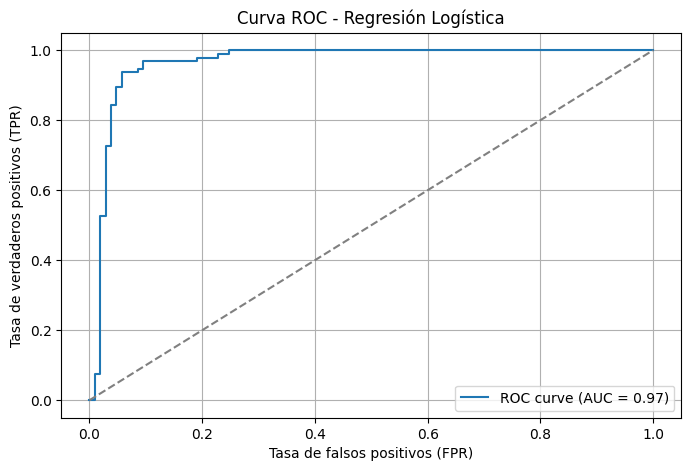

In [ ]:
y_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC: {roc:.4f}")
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.grid()
plt.show()


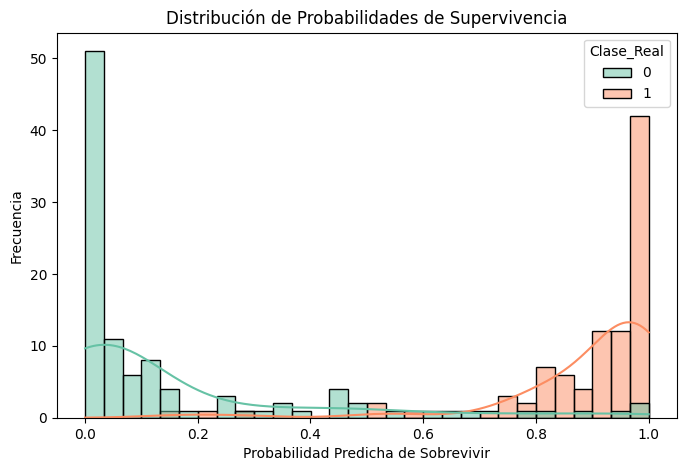

In [ ]:
df_proba = pd.DataFrame({
    'Probabilidad_Sobrevivir': y_proba,
    'Clase_Real': y_test.reset_index(drop=True)
})

plt.figure(figsize=(8, 5))
sns.histplot(data=df_proba, x='Probabilidad_Sobrevivir', hue='Clase_Real', bins=30, kde=True, palette='Set2')
plt.title('Distribución de Probabilidades de Supervivencia')
plt.xlabel('Probabilidad Predicha de Sobrevivir')
plt.ylabel('Frecuencia')
plt.show()


##Analisis


In [ ]:
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.935

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       105
           1       0.90      0.97      0.93        95

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200


Matriz de confusión:
[[95 10]
 [ 3 92]]


**1. Exactitud General (Accuracy): 0.68**
El modelo predice correctamente en el 68% de los casos.

Este valor es aceptable, especialmente considerando que el problema no está perfectamente balanceado (más ejemplos de False que de True).

**Interpretación:**

Clase False (No sobrevive):

Alta precisión: cuando el modelo predice que alguien no sobrevive, suele acertar.

Pero menor recall: a veces no detecta correctamente a los que realmente no sobreviven.

Clase True (Sobrevive):

Menor precisión: hay más falsos positivos (predice que sobrevive, pero no).

Buen recall: detecta bien a quienes sí sobreviven.

